## TASK 3 - Scene recognition with Bag of Visual Words

Group Number: Group 5

### 1 Data import and Preparation

Complete the class ***SceneDataset*** in ***dataset.py*** and load the training and test dataset. (images and class labels)

In [1]:
%load_ext autoreload
%autoreload 1
%aimport features, dataset, utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import numpy as np
import features
import dataset
import utils
import os

In [ ]:
if not os.path.exists(os.path.join(os.getcwd(), 'results')):
    os.makedirs(os.path.join(os.getcwd(), 'results'))

#student_code start
from dataset import SceneDataset

#IF YOU HAVE ISSUES WITH THE PATHS, ADJUST THE PATHS BELOW TO POINT TO THE data/scene/train AND data/scene/test FOLDERS!!

train_path = os.path.join(os.getcwd(), "..", "data", "data", "scene", "train")
test_path  = os.path.join(os.getcwd(), "..", "data", "data", "scene", "test")

train_ds = SceneDataset(train_path)
test_ds  = SceneDataset(test_path)

train_images = train_ds.images
train_labels = train_ds.labels

test_images  = test_ds.images
test_labels  = test_ds.labels

# Using the (sorted) class list from train as the canonical order
class_names = train_ds.class_names

# Same class ordering in train and test
assert train_ds.class_names == test_ds.class_names, "Train/Test class folder order differs!"
#student_code end
print('Imported test data: ',len(test_images))
print('Imported training data: ', len(train_images))
print(class_names)


Imported test data:  400
Imported training data:  1600
['bedroom', 'coast', 'forest', 'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street', 'tallbuilding']


###  2 Build Vocabulary and Clusters

Extract SIFT features from the training data using ***features.extract_dsift(..)*** and then utilize the descriptors to generate visual words with ***KMeans(...).fit(...).cluster_centers_*** from ***sklearn.neighbors***. Set the sample size per image at about **100** and a step size around **5**. For cluster size, try a value around **50**. You can adapt the paramater to achieve better results. If clustering takes too long, have a look at the parameters **n_init** and **max_iter** of ***KMeans(...)***.

_***HINT:***_
***KMeans(..)*** expects the features to be a stacked 2D matrix instead of a list (np.vstack(...)).


In [3]:
#student code start
# Extracting features from training images
stepsize = 5
num_samples = 100

train_desc_list = features.extract_dsift(train_images, stepsize=stepsize, num_samples=num_samples)

# Stacking list-of-arrays into one array for KMeans
train_desc = np.vstack(train_desc_list).astype(np.float32)

print("Stacked descriptors shape:", train_desc.shape)  

#kmeans clustering to build visual vocabulary
Nc = 50  # vocabulary size

kmeans = KMeans(
    n_clusters=Nc,
    random_state=0,
    n_init=5,        
    max_iter=200     
)

kmeans.fit(train_desc)

vocab_centers = kmeans.cluster_centers_  # shape: (Nc, 128)

print("Vocabulary shape:", vocab_centers.shape)

codebook = vocab_centers

#student code end

DSIFT Extraction: 9.333467499993276  seconds
Stacked descriptors shape: (160000, 128)
Vocabulary shape: (50, 128)


###  3 Classification

Generat a histogram per image using the centroids. First extract the dense SIFT features of the training set again. This time use a smaller stepsize (eg. 1 or 2) and take all samples.

After, implement ***count_visual_words(..)*** in ***features.py*** to obtain a histogram per image. Build a kNN classifier with ***KNeighborsClassifier(..)*** and fit the the model with the histogram data of the training images and training labels. Set the neighbourhood size to **3**.


In [4]:
#student code start
from sklearn.neighbors import KNeighborsClassifier

# 1) Extracting dense SIFT for representation (using stepsize=2 for no subsampling)
train_desc_dense = features.extract_dsift(train_images, stepsize=2)  # no subsampling
test_desc_dense  = features.extract_dsift(test_images,  stepsize=2)

# 2) Convert to BoVW histograms using the vocabulary (centroids from KMeans)
train_hists = features.count_visual_words(train_desc_dense, vocab_centers)
test_hists  = features.count_visual_words(test_desc_dense,  vocab_centers)

# Turn list of histograms into arrays
X_train = np.vstack(train_hists).astype(np.float32)
X_test  = np.vstack(test_hists).astype(np.float32)

y_train = np.array(train_labels, dtype=np.int32)
y_test  = np.array(test_labels, dtype=np.int32)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

# 3) kNN classifier (k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# 4) Predict and evaluate
y_pred = knn.predict(X_test)
acc = knn.score(X_test, y_test)
print("BoVW kNN accuracy:", acc)


#student code end

DSIFT Extraction: 13.385804400008055  seconds
DSIFT Extraction: 3.082750399989891  seconds
Counting visual words: 23.09761409999919  seconds
Counting visual words: 5.7536180000024615  seconds
X_train: (1600, 50) X_test: (400, 50)
BoVW kNN accuracy: 0.4575


### 4 Evaluation

Examine the accuracy of your model by extracting the dense SIFT points of the test set with the same stepsize as before, generate the histogams and predict the labels of the test set with the previously fitted classifier. Plot your results with ***utils.plot_confusion_matrix(..)***.

_***HINT:***_
Use the methods ***predict(..)*** and ***score(..)*** on the KNN classifier.


***Submission:*** Save the confusion matrix with the KNN score as **task3_accuracy_test_data.png** using ***utils.plot_confusion_matrix(..)***.



Test accuracy: 0.4575


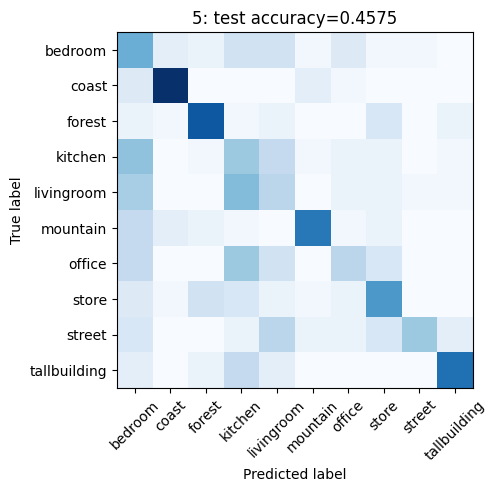

In [5]:
#student code start
# Prediction and score on test set
y_pred = knn.predict(X_test)
acc = knn.score(X_test, y_test)

print("Test accuracy:", acc)


utils.plot_confusion_matrix(
    gt_labels=y_test,
    predicted=y_pred,
    accuracy=acc,
    class_names=class_names,
    group_no=5,  
    name="task3_accuracy_test_data.png"  
)
#student code end

***
#### Q1: Analyze the confusion matrix. Are there classes which can be more easily identified than others. What could be the reason? What classes perform worst, and explain your answer.


The confusion matrix shows that some scene categories are easier to recognize than others. Coast, forest, mountain, and tallbuilding are classified  well. They have distinctive visual patterns, for example a large homogeneous region (coast), repetitive textures (forest), strong edge structures (mountain), or regular geometry (tallbuilding). Dense SIFT descriptors are well suited to capture these characteristic local gradient patterns, making these classes more separable.

In contrast, bedroom, livingroom, kitchen, and office perform worst and are frequently confused with each other. The indoor scenes share many similar visual elements, such as furniture, flat surfaces, and comparable textures, which lead to similar local SIFT features. Since the Bag of Visual Words representation ignores spatial layout and object arrangement, it cannot distinguish how these elements are organized within the scene, which results in high confusion.


Take some own test images and investigate if they can be correctly classified with you trained model. For instance, take a photo of your own kitchen or living room and classify it. You should at least test one photo from three of the ten categories. Make sure the images are resized and cropped to 100x100.

***Submission:*** Save the confusion matrix with the model score as **task3_accuracy_custom_data.png** using ***utils.plot_confusion_matrix(..)***.

DSIFT Extraction: 0.03006689999892842  seconds
Counting visual words: 0.04071990000375081  seconds
GT labels:      [0 4 6]
Predicted:      [0 4 6]
Custom accuracy: 1.0


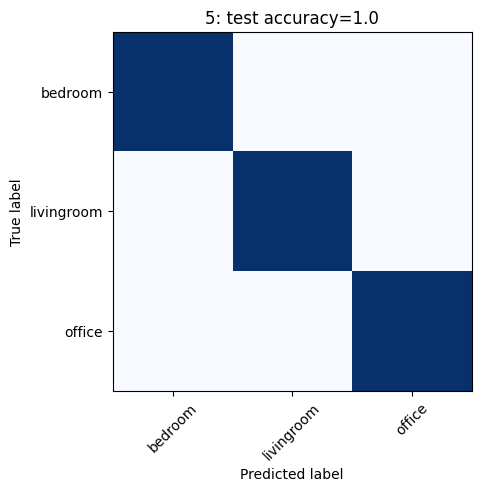

In [6]:
import cv2
custom_dir = os.path.join(os.getcwd(), "own_photos")

custom_files = [
    ("bedroom",    os.path.join(custom_dir, "bedroom.jpg")),
    ("livingroom", os.path.join(custom_dir, "livingroom.jpg")),
    ("office",     os.path.join(custom_dir, "office.jpg")),
]

custom_images = []
custom_gt = []

for cls, p in custom_files:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {p}")

    img = img.astype(np.float32) / 255.0

    custom_images.append(img)

    if cls not in class_names:
        raise ValueError(f"Class '{cls}' not found in class_names. Available: {class_names}")
    custom_gt.append(class_names.index(cls))

custom_gt = np.array(custom_gt, dtype=np.int32)

#  BoVW representation 
custom_desc_dense = features.extract_dsift(custom_images, stepsize=2)
custom_hists = features.count_visual_words(custom_desc_dense, vocab_centers)
X_custom = np.vstack(custom_hists).astype(np.float32)

# Predicting with the BoVW kNN model 
custom_pred = knn.predict(X_custom)
custom_acc = float(np.mean(custom_pred == custom_gt))

print("GT labels:     ", custom_gt)
print("Predicted:     ", custom_pred)
print("Custom accuracy:", custom_acc)

# Plotting and saving confusion matrix 
utils.plot_confusion_matrix(
    gt_labels=custom_gt,
    predicted=custom_pred,
    accuracy=custom_acc,
    class_names=class_names,
    group_no=5,  
    name="task3_accuracy_custom_data.png"
)

### 5 Beyond Bag Of Words: Vector of Locally Aggregated Descriptors (VLAD)

Finally, we want to investigate an extension of the traditional bag of words model, called **Vector of Locally Aggregated Descriptors (VLAD)**, which not only considers the cluster assignment, but also uses the distance to the nearest centroid (refered to as **residual**).

Implement the VLAD algorithm in **features.calculate_vlad_descriptors** according to the task description and run the whole classification again by replacing the bag of words descriptors with VLAD. Compare the performance and discuss the advantages and disadvantages. Can you think of any further extensions?

***Submission:*** Save the confusion matrix with the model score as **task3_accuracy_vlad_descriptor.png** using ***utils.plot_confusion_matrix(..)***.

DSIFT Extraction: 12.343778599999496  seconds
DSIFT Extraction: 2.93522440000379  seconds
Counting visual words: 20.558360600000015  seconds
Counting visual words: 5.031151200004388  seconds
X_train_vlad: (1600, 6400) X_test_vlad: (400, 6400)
VLAD kNN accuracy: 0.5275


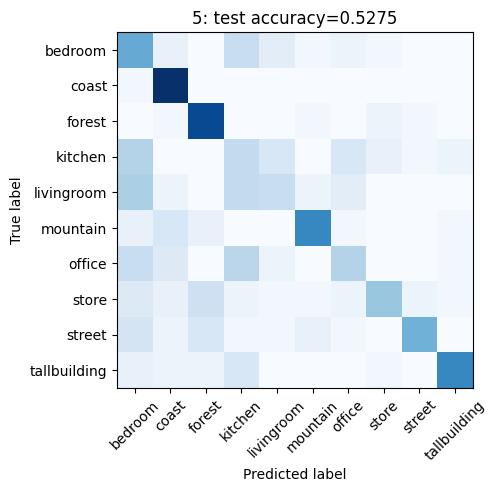

In [7]:
#student code start

# 1) Dense SIFT 
train_desc_dense = features.extract_dsift(train_images, stepsize=2)
test_desc_dense  = features.extract_dsift(test_images,  stepsize=2)

# 2) VLAD descriptors
train_vlad_list = features.calculate_vlad_descriptors(train_desc_dense, vocab_centers)
test_vlad_list  = features.calculate_vlad_descriptors(test_desc_dense,  vocab_centers)

X_train_vlad = np.vstack(train_vlad_list).astype(np.float32)  # (num_train, Nc*128)
X_test_vlad  = np.vstack(test_vlad_list).astype(np.float32)   # (num_test,  Nc*128)

y_train = np.array(train_labels, dtype=np.int32)
y_test  = np.array(test_labels, dtype=np.int32)

print("X_train_vlad:", X_train_vlad.shape, "X_test_vlad:", X_test_vlad.shape)

# 3) kNN (k=3)
knn_vlad = KNeighborsClassifier(n_neighbors=3)
knn_vlad.fit(X_train_vlad, y_train)

# 4) Predict + score
y_pred_vlad = knn_vlad.predict(X_test_vlad)
acc_vlad = knn_vlad.score(X_test_vlad, y_test)
print("VLAD kNN accuracy:", acc_vlad)

# 5) Confusion matrix and save
utils.plot_confusion_matrix(
    gt_labels=y_test,
    predicted=y_pred_vlad,
    accuracy=acc_vlad,
    class_names=class_names,
    group_no=5,  
    name="task3_accuracy_vlad_descriptor.png"
)

#student code end

VLAD keeps more information than BoVW. Not just “which cluster” but also how descriptors deviate from the centroid (residuals), so it’s more discriminative. It also typically improves accuracy at similar vocabulary sizes.


The disadvantages are a much higher dimensional descriptor (Nc*128, e.g. 50*128=6400) , so more memory and compute for kNN. Still loses spatial layout (like BoVW), and can be sensitive to strongfeatures unless extra normalization is added.

Some further extenions are: Spatial Pyramid and Fisher Vectors.
